In [1]:
import h5py
import os
import numpy as np

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

file = h5py.File('processed_data.h5','r+') 

#Retrieves all the preprocessed training and validation\testing data from a file

X_train = file['X_train'][...]
Y_train = file['Y_train'][...]
X_test = file['X_test'][...]
Y_test = file['Y_test'][...]

# Unpickles and retrieves class names and other meta informations of the database
classes = unpickle('cifar-10-batches-py/batches.meta') #keyword for label = label_names

#Yes, the following steps are redundant. But, they're here for 'reasons'.
#It's a long story.

X_train_feed = X_train
X_test_feed = X_test

In [2]:
import tensorflow as tf

In [3]:
# Copy pasted the model from Model(WRN).ipynb file to initialize all the variables properly which needs to be restored from 
# the saved model file.
# (There's probably a better way to do this without rewriting all these steps but this is basically a quick fix I managed 
# to use to properly restore a saved model and use it for making predictions)

#Hyper Parameters!
learning_rate = 0.01
batch_size = 1
training_iters = 200*(int(len(X_train)/batch_size))
layers = 16

# 1 conv + 3 convblocks*(3 conv layers *1 group for each block + 2 conv layers*(N-1) groups for each block [total 1+N-1 = N groups]) = layers
# 3*2*(N-1) = layers - 1 - 3*3
# N = (layers -10)/6 + 1

N = ((layers-10)/6)+1
K = 4 #(deepening factor)

#(N and K are used in the same sense as defined here: https://arxiv.org/abs/1605.07146)

n_classes = len(classes['label_names']) # another useless step that I made because of certain reasons. 

# tf Graph input

x = tf.placeholder(tf.float32, [1,32, 32, 3])
y = tf.placeholder(tf.float32, [1,n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
phase = tf.placeholder(tf.bool, name='phase') 
#(Phase = true means training is undergoing. The contrary is ment when Phase is false.)

# Create some wrappers for simplicity

def conv2d(x,shape,strides):
    # Conv2D wrapper
    W = tf.Variable(tf.truncated_normal(shape=shape,stddev=5e-2))
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    # Didn't add bias because I read somewhere it's not necessary to add a bias if batch normalization is to be performed later
    # May be add L2 regularization or something here if you wish to.
    return x

def activate(x,phase):
    #wrapper for performing batch normalization and relu activation
    x = tf.contrib.layers.batch_norm(x, center=True, scale=True,variables_collections=["batch_norm_non_trainable_variables_collection"],updates_collections=None, decay=0.9,is_training=phase,zero_debias_moving_mean=True, fused=True)
    return tf.nn.relu(x,'relu')


def wideres33block(X,N,K,iw,bw,s,dropout,phase):
    
    # Creates N no. of 3,3 type residual blocks with dropout that consitute the conv2/3/4 blocks
    # with widening factor K and X as input. s is stride and bw is base width (no. of filters before multiplying with k)
    # iw is input width.
    # (see https://arxiv.org/abs/1605.07146 paper for details on the block)
    # In this case, dropout = probability to keep the neuron enabled.
    # phase = true when training, false otherwise.
    
    conv33_1 = conv2d(X,[3,3,iw,bw*K],s)
    conv33_1 = activate(conv33_1,phase)
    
    conv33_1 = tf.nn.dropout(conv33_1,dropout)
    
    conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1)
    conv_s_1 = conv2d(X,[1,1,iw,bw*K],s) #shortcut connection
    
    caddtable = tf.add(conv33_2,conv_s_1)
    
    #1st of the N blocks for conv2/3/4 block ends here. The rest of N-1 blocks will be implemented next with a loop.

    for i in range(0,N-1):
        
        C = caddtable
        Cactivated = activate(C,phase)
        
        conv33_1 = conv2d(Cactivated,[3,3,bw*K,bw*K],1)
        conv33_1 = activate(conv33_1,phase)
        
        conv33_1 = tf.nn.dropout(conv33_1,dropout)
            
        conv33_2 = conv2d(conv33_1,[3,3,bw*K,bw*K],1)
        caddtable = tf.add(conv33_2,C)
    
    return activate(caddtable,phase)


    
def WRN(x, dropout, phase): #Wide residual network

    conv1 = conv2d(x,[3,3,3,16],1)
    conv1 = activate(conv1,phase)
    
    conv2 = wideres33block(conv1,N,K,16,16,1,dropout,phase)
    conv3 = wideres33block(conv2,N,K,16*K,32,2,dropout,phase)
    conv4 = wideres33block(conv3,N,K,32*K,64,2,dropout,phase)

    pooled = tf.nn.avg_pool(conv4,ksize=[1,8,8,1],strides=[1,1,1,1],padding='VALID')
    
    #Initialize weights and biases for fully connected layers
    wd1 = tf.Variable(tf.truncated_normal([1*1*64*K, 64*K],stddev=5e-2))
    bd1 = tf.Variable(tf.constant(0.1,shape=[64*K]))
    wout = tf.Variable(tf.random_normal([64*K, n_classes]))
    bout = tf.Variable(tf.constant(0.1,shape=[n_classes]))

    # Fully connected layer
    # Reshape pooling layer output to fit fully connected layer input
    
    fc1 = tf.reshape(pooled, [-1, wd1.get_shape().as_list()[0]])   
    fc1 = tf.add(tf.matmul(fc1, wd1), bd1)
    fc1 = tf.nn.relu(fc1)

    #fc1 = tf.nn.dropout(fc1, dropout) #Not sure if I should or should not apply dropout here.
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, wout), bout)
    
    gradX = tf.gradients(conv2,x)
    gradX = tf.reshape(gradX,[32,32,3])
    gradX = tf.reduce_sum(gradX,2)
    #gradX = tf.nn.sigmoid(gradX)

    return out,gradX

# Construct model
model,gradX = WRN(x,keep_prob,phase)

# Define loss and optimizer

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
prediction = tf.nn.softmax(logits=model)



global_step = tf.Variable(0)

#learning_rate = tf.train.exponential_decay(init_lr,global_step*batch_size, decay_steps=len(X_train), decay_rate=0.95, staircase=True)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = 0.9, use_nesterov=True).minimize(cost,global_step=global_step)

# Evaluate model
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [4]:

# Converts any image into a square by cropping
def ToSquare(img):
    if img.shape[0]>img.shape[1]:
        extra=img.shape[0]-img.shape[1]
        if extra%2==0:
            crop = img[extra//2:(-extra//2):]
        else:
            crop = img[max(0,1+extra//2):min(-1,(-extra//2)),:]
    elif img.shape[1]>img.shape[0]:
        extra=img.shape[1]-img.shape[0]
        if extra%2==0:
            crop = img[:,extra//2:(-extra//2)]
        else:
            crop = img[:,max(0,1+extra//2):min(-1,(-extra//2))]
    elif img.shape[1]==img.shape[0]:
        crop=img
    return crop

# Applies global contrast normalization.
def global_contrast_normalization(img,s, lmda, epsilon):
    X = np.array(img)
    X_average = np.mean(X)
    X = X - X_average
    contrast = np.sqrt(lmda + np.mean(X**2))
    X = s * X / max(contrast, epsilon)
    return X

# Performs all necessary preprocessing on an image before feeding it to the network for prediction.
def imgprocess(img):
    SqrImg = ToSquare(img)
    TinyImg = imresize(SqrImg,(32,32))
    GcnImg =  global_contrast_normalization(TinyImg,1, 10, 0.000000001)
    return GcnImg

INFO:tensorflow:Restoring parameters from Model_Backup/model.ckpt
Enter relative path to the image: horse2.jpg


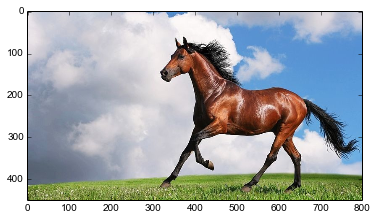

After Processing: 


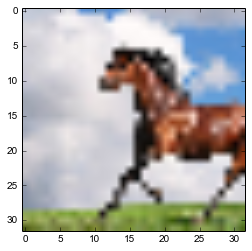

100 Most influential pixels (in black):


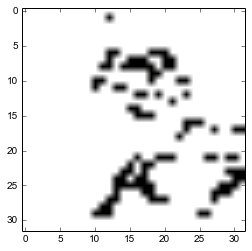


There's about a 99.831% chance that there is at least one bird in the image

The whole probability distribution:

airplane: 0.148%
automobile: 0.000%
bird: 99.831%
cat: 0.000%
deer: 0.020%
dog: 0.000%
frog: 0.000%
horse: 0.000%
ship: 0.001%
truck: 0.000%

Enter relative path to the image: car3.jpg


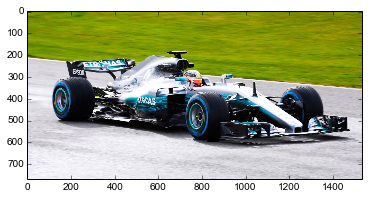

After Processing: 


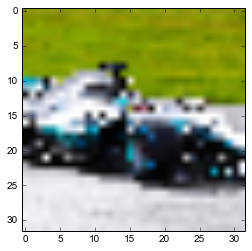

100 Most influential pixels (in black):


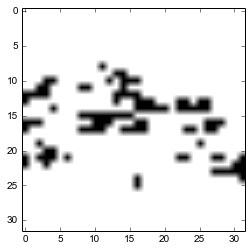


There's about a 54.035% chance that there is at least one frog in the image

The whole probability distribution:

airplane: 13.371%
automobile: 27.672%
bird: 0.042%
cat: 4.181%
deer: 0.001%
dog: 0.000%
frog: 54.035%
horse: 0.008%
ship: 0.000%
truck: 0.689%

Enter relative path to the image: bird.jpg


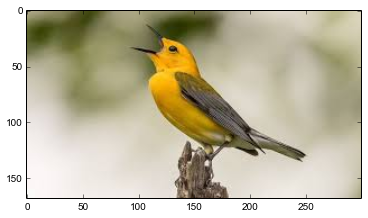

After Processing: 


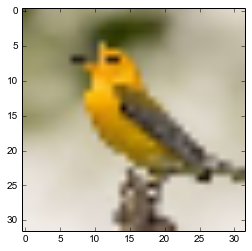

100 Most influential pixels (in black):


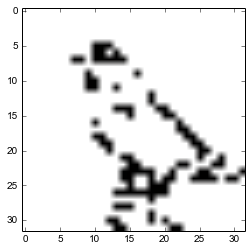


There's about a 100.000% chance that there is at least one bird in the image

The whole probability distribution:

airplane: 0.000%
automobile: 0.000%
bird: 100.000%
cat: 0.000%
deer: 0.000%
dog: 0.000%
frog: 0.000%
horse: 0.000%
ship: 0.000%
truck: 0.000%

Enter relative path to the image: ls.jpg


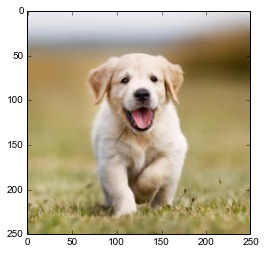

After Processing: 


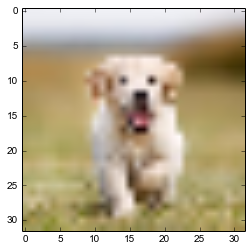

100 Most influential pixels (in black):


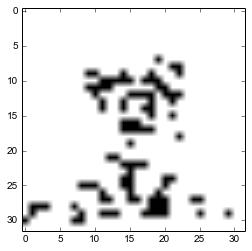


There's about a 99.854% chance that there is at least one dog in the image

The whole probability distribution:

airplane: 0.000%
automobile: 0.000%
bird: 0.105%
cat: 0.041%
deer: 0.000%
dog: 99.854%
frog: 0.000%
horse: 0.000%
ship: 0.000%
truck: 0.000%

Enter relative path to the image: cat.jpg


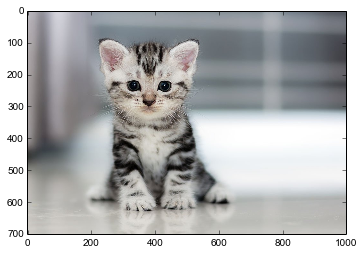

After Processing: 


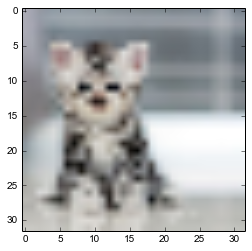

100 Most influential pixels (in black):


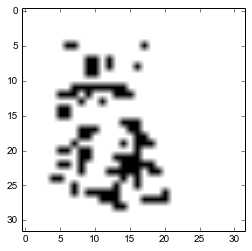


There's about a 99.253% chance that there is at least one cat in the image

The whole probability distribution:

airplane: 0.000%
automobile: 0.000%
bird: 0.282%
cat: 99.253%
deer: 0.000%
dog: 0.001%
frog: 0.000%
horse: 0.463%
ship: 0.000%
truck: 0.000%

Enter relative path to the image: car.jpg


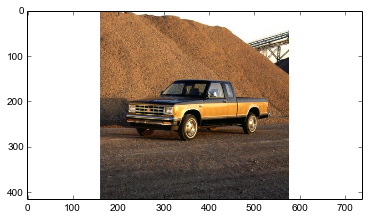

After Processing: 


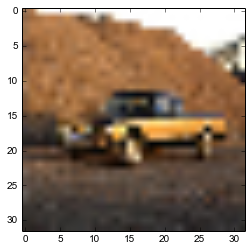

100 Most influential pixels (in black):


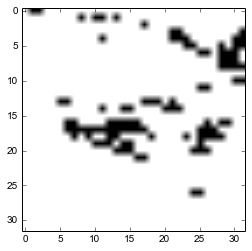


There's about a 58.512% chance that there is at least one bird in the image

The whole probability distribution:

airplane: 16.885%
automobile: 0.796%
bird: 58.512%
cat: 19.012%
deer: 4.099%
dog: 0.000%
frog: 0.116%
horse: 0.061%
ship: 0.107%
truck: 0.413%

Enter relative path to the image: smalltruck.jpg


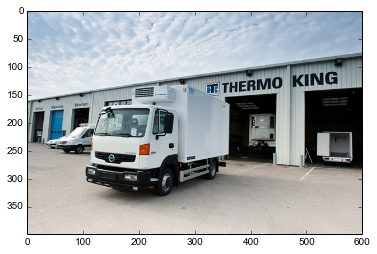

After Processing: 


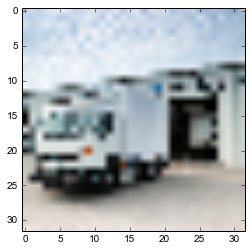

100 Most influential pixels (in black):


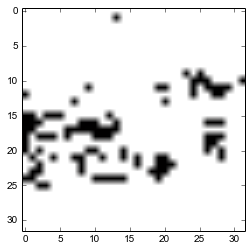


There's about a 99.884% chance that there is at least one truck in the image

The whole probability distribution:

airplane: 0.105%
automobile: 0.011%
bird: 0.000%
cat: 0.000%
deer: 0.000%
dog: 0.000%
frog: 0.000%
horse: 0.000%
ship: 0.000%
truck: 99.884%

Enter relative path to the image: STOP


In [6]:
import matplotlib.pyplot as plt
from scipy.misc import toimage
from scipy.misc import imresize
%matplotlib inline

filename = ""

with tf.Session() as sess: # Begin Session
    
    saver = tf.train.Saver()
    saver.restore(sess, 'Model_Backup/model.ckpt')
    sess.run(tf.global_variables())
    
    while True:
        
        filename = raw_input("Enter relative path to the image: ")
        if filename == "STOP": # Entering "STOP" as a filename will break the loop. 
            break
        img = open(filename,'r')
        img = plt.imread(img)

        plt.imshow(img)
        plt.show()

        TestImg_ = imgprocess(img)
        
        TestImg = np.asarray(TestImg_)
        TestImg = TestImg.astype(np.float32)
        
        print "After Processing: "
        plt.imshow(toimage(TestImg_))
        plt.show()

        result,object_test = sess.run([prediction,gradX],feed_dict={x: TestImg.reshape((1,32,32,3)),keep_prob: 1,
                                                                    phase: False})
    
        model_prediction = result[0]
        
        most_probable_class = np.argmax(model_prediction)
        
        pos_object_test = np.fabs(object_test)
        #pos_object_test = object_test
        sortedobject = np.flip(np.sort(pos_object_test,None),0)
        threshold = sortedobject[99]
        
        print "100 Most influential pixels (in black):"
        for i in xrange(0,32):
            for j in xrange(0,32):
                if pos_object_test[i][j] >= threshold:
                    TestImg[i][j][0] = 0
                else:
                    TestImg[i][j][0:3] = 999
        plt.imshow(toimage(TestImg))
        plt.show()
        
        print "\nThere's about a %.3f%%"%(model_prediction[most_probable_class]*100) + \
              " chance that there is at least one "+classes['label_names'][most_probable_class]+" in the image\n"
        
        print "The whole probability distribution:\n"

        for i in xrange(0,10):
            print str(classes['label_names'][i])+": %.3f%%"%(model_prediction[i]*100)
        
        
        print("")
        